# <span style="color:#2832C2">CREDIT CARD FRAUD DETECTION</span>

##### Nguyễn Thành Nam – N21DCCN150
##### Sỳ Hưng – N22DCCN137
##### Uông Ngọc Sơn – N22DCCI033

#### Đồ án hướng tới việc xây dựng mô hình phát hiện gian lận thẻ tín dụng có độ chính xác cao, đảm bảo nhận diện tốt các giao dịch gian lận hiếm mà không gây ra nhiều báo động giả.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra  # numpy: hỗ trợ tính toán ma trận, đại số tuyến tính
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)  # pandas: xử lý dữ liệu dạng bảng (DataFrame)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## <span style="color:#2832C2">Giới thiệu</span>
Notebook này nhằm tạo ra để phát hiện giao dịch gian lận với các yêu cầu sau
- Mục tiêu: Phát hiện các giao dịch thẻ tín dụng gian lận.  
- Mô hình: Hồi quy Logistic, Random Forest, XGBoost  
- Đánh giá: Precision, Recall, F1-score, ROC-AUC  
- Kết quả mong muốn: Xây dựng mô hình có độ chính xác cao cho các trường hợp gian lận hiếm gặp.

## <span style="color:#2832C2">Bước tiền xử lý</span>
- nhập các thư viện cần thiết
- kiểm tra thông tin dữ liệu
- kiểm tra giá trị null
- chuẩn hóa dữ liệu (feature scaling) 
- kiểm tra giá trị trùng lặp

In [4]:
!pip install imbalanced-learn==0.10.1


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import warnings
import numpy as np  # numpy: hỗ trợ tính toán ma trận, đại số tuyến tính
import pandas as pd  # pandas: xử lý dữ liệu dạng bảng (DataFrame)
import matplotlib.pyplot as plt  # matplotlib: vẽ biểu đồ trực quan
import seaborn as sns  # seaborn: vẽ biểu đồ nâng cao, trực quan dữ liệu
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler  # StandardScaler: chuẩn hóa dữ liệu (trung bình = 0, độ lệch chuẩn = 1)
from sklearn.model_selection import train_test_split  # train_test_split: tách dữ liệu thành tập train và test
from sklearn.metrics import (
    confusion_matrix,  # confusion_matrix: ma trận nhầm lẫn để đánh giá mô hình
    classification_report,  # classification_report: báo cáo Precision, Recall, F1-score
    accuracy_score,  # accuracy_score: độ chính xác của mô hình
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,  # roc_auc_score: thước đo AUC (Area Under Curve)
    roc_curve,  # roc_curve: đường cong ROC để so sánh mô hình
    auc
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [6]:
credit_card_transation = pd.read_csv('creditcard.csv')

In [7]:
# We keep the original data in credit_card_transation and create a dupplicate data
# We then work on the duplicate data.

data = credit_card_transation.copy()
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [8]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Class'])
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)
print("Fraud ratio train:", y_train.mean())
print("Fraud ratio test :", y_test.mean())


(227845, 30) (56962, 30)
Fraud ratio train: 0.001729245759178389
Fraud ratio test : 0.0017204452090867595


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

preprocess = ColumnTransformer(
    transformers=[('amount_scaler', StandardScaler(), ['Amount'])],
    remainder='passthrough'
)

lr_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

lr_pipe.fit(X_train, y_train)  # <-- TRAIN

y_pred_lr = lr_pipe.predict(X_test)
y_proba_lr = lr_pipe.predict_proba(X_test)[:, 1]

print("=== Logistic Regression (Pipeline) ===")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC :", average_precision_score(y_test, y_proba_lr))


=== Logistic Regression (Pipeline) ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Confusion Matrix:
 [[55402  1462]
 [    8    90]]
ROC-AUC: 0.9727109365130409
PR-AUC : 0.7255519434369339


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=50, max_depth=None, n_jobs=-1, random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)  # <-- TRAIN

y_pred_rf = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("=== Random Forest (Pipeline) ===")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC :", average_precision_score(y_test, y_proba_rf))


=== Random Forest (Pipeline) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56859     5]
 [   18    80]]
ROC-AUC: 0.9481544939303802
PR-AUC : 0.8658691581025182


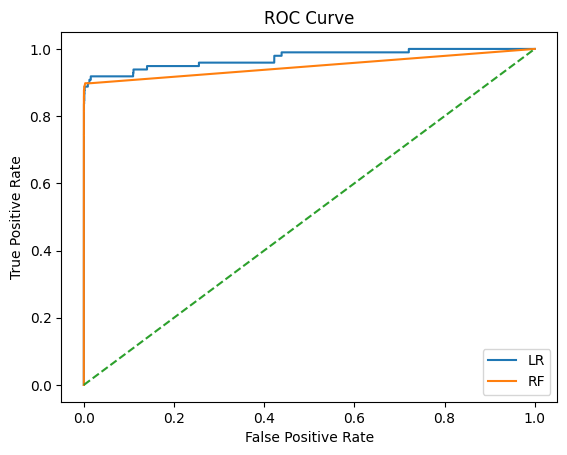

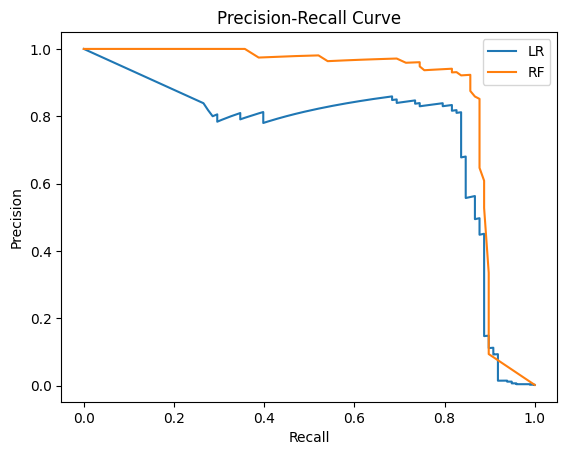

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label="LR")
plt.plot(fpr_rf, tpr_rf, label="RF")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR curve
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure()
plt.plot(rec_lr, prec_lr, label="LR")
plt.plot(rec_rf, prec_rf, label="RF")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [12]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

results = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Precision": precision_score(y_test, y_pred_lr),
        "Recall": recall_score(y_test, y_pred_lr),
        "F1": f1_score(y_test, y_pred_lr),
        "ROC-AUC": roc_auc_score(y_test, y_proba_lr),
        "PR-AUC": average_precision_score(y_test, y_proba_lr),
    },
    {
        "Model": "Random Forest",
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1": f1_score(y_test, y_pred_rf),
        "ROC-AUC": roc_auc_score(y_test, y_proba_rf),
        "PR-AUC": average_precision_score(y_test, y_proba_rf),
    }
])

results


,Model,Precision,Recall,F1,ROC-AUC,PR-AUC
0,Logistic Regression,0.057990,0.918367,0.109091,0.972711,0.725552
1,Random Forest,0.941176,0.816327,0.874317,0.948154,0.865869


## Đánh giá nâng cao: PR Curve, bảng so sánh metrics, Threshold tuning, Cross-validation

1) **PR Curve + PR-AUC** (phù hợp fraud detection)
2) **Bảng so sánh metrics** giữa các mô hình
3) **Threshold tuning** (không mặc định 0.5)
4) **Cross-validation** (kiểm tra độ ổn định, ít nhất cho Logistic Regression)


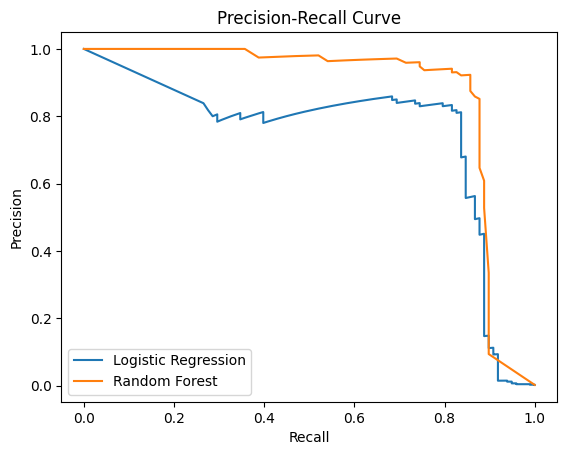

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# PR Curve cho Logistic Regression và Random Forest
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure()
plt.plot(rec_lr, prec_lr, label='Logistic Regression')
plt.plot(rec_rf, prec_rf, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [14]:
# Bảng so sánh metrics (đưa thẳng vào báo cáo)
results_sorted = results.sort_values(by='PR-AUC', ascending=False).reset_index(drop=True)
results_sorted


,Model,Precision,Recall,F1,ROC-AUC,PR-AUC
0,Random Forest,0.941176,0.816327,0.874317,0.948154,0.865869
1,Logistic Regression,0.057990,0.918367,0.109091,0.972711,0.725552


Best threshold (LR) theo F1: 0.5
threshold    0.500000
precision    0.057990
recall       0.918367
f1           0.109091
Name: 49, dtype: float64


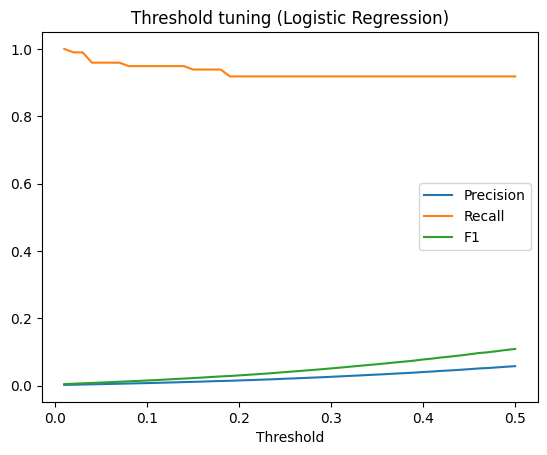

Confusion Matrix (LR, tuned threshold):
[[55402  1462]
 [    8    90]]


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_report(y_true, y_proba, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.50, 50)
    rows = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        rows.append({
            'threshold': float(t),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0)
        })
    df_t = pd.DataFrame(rows)
    best = df_t.loc[df_t['f1'].idxmax()]
    return df_t, best

# Threshold tuning cho Logistic Regression
lr_thr_table, lr_best = threshold_report(y_test, y_proba_lr)
print('Best threshold (LR) theo F1:', float(lr_best['threshold']))
print(lr_best)

plt.figure()
plt.plot(lr_thr_table['threshold'], lr_thr_table['precision'], label='Precision')
plt.plot(lr_thr_table['threshold'], lr_thr_table['recall'], label='Recall')
plt.plot(lr_thr_table['threshold'], lr_thr_table['f1'], label='F1')
plt.xlabel('Threshold')
plt.title('Threshold tuning (Logistic Regression)')
plt.legend()
plt.show()

# Áp dụng threshold tốt nhất để xem confusion matrix
lr_best_t = float(lr_best['threshold'])
y_pred_lr_best = (y_proba_lr >= lr_best_t).astype(int)
print('Confusion Matrix (LR, tuned threshold):')
print(confusion_matrix(y_test, y_pred_lr_best))


In [16]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# Cross-validation cho Logistic Regression (Pipeline)
# Dùng PR-AUC (average_precision) và ROC-AUC để đánh giá ổn định
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_validate(
    lr_pipe,
    X, y,
    cv=cv,
    scoring={'roc_auc': 'roc_auc', 'pr_auc': 'average_precision'},
    n_jobs=-1,
    return_train_score=False
)

print('CV ROC-AUC:  mean =', cv_scores['test_roc_auc'].mean(), ' std =', cv_scores['test_roc_auc'].std())
print('CV PR-AUC :  mean =', cv_scores['test_pr_auc'].mean(), ' std =', cv_scores['test_pr_auc'].std())


CV ROC-AUC:  mean = 0.979176824051347  std = 0.00826406924004268
CV PR-AUC :  mean = 0.7423194010320355  std = 0.019051908754052587


In [17]:
# few rows checking
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [18]:
data.isnull().sum() # not null values

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [19]:
data.info() # Only Numeric values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

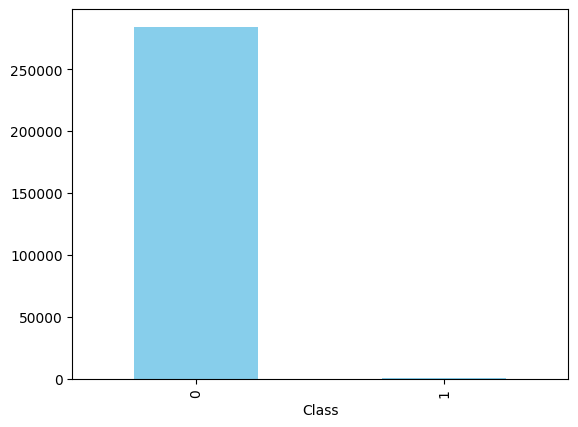

In [20]:
# Check the distribution of Class - EXTREME IMBALANCED - 99.8% class 0 
data['Class'].value_counts().plot(kind='bar', color='skyblue')
data['Class'].value_counts(normalize=True) * 100

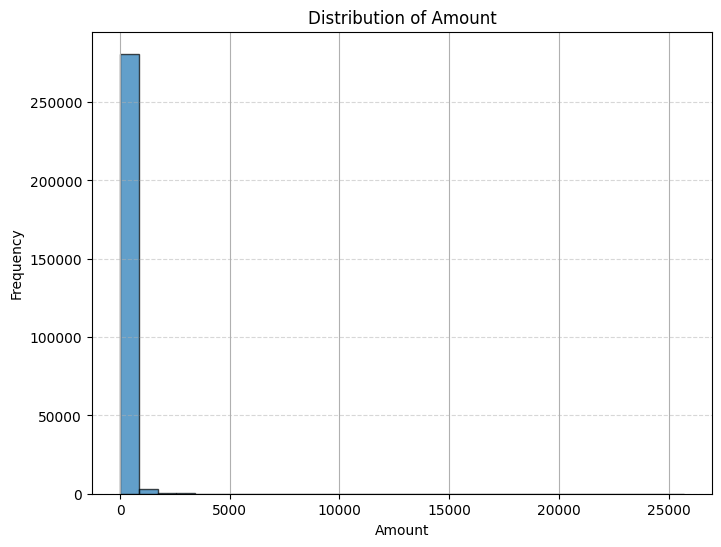

In [21]:
# We all know V1-V28 columns all are PCA (we can assume they had been scaled to do PCA) -> focus on other columns -> Time, Amount
plt.figure(figsize=(8, 6))
data['Amount'].hist(bins=30, edgecolor='black', alpha=0.7)

plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show() # Pay attention to amount values we can get (x-axis) -> should scale to much smaller range

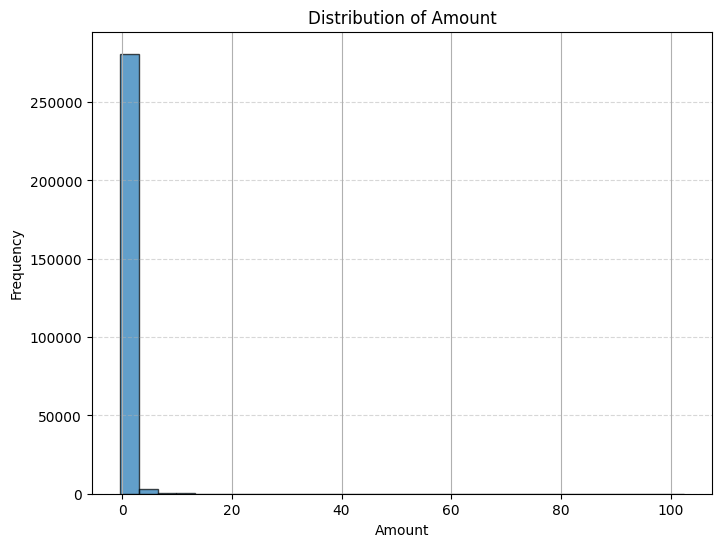

In [22]:
standard_scaler = StandardScaler() # choose to use standard scaler  # StandardScaler: chuẩn hóa dữ liệu (trung bình = 0, độ lệch chuẩn = 1)
data['Amount'] = standard_scaler.fit_transform(data['Amount'].values.reshape((-1, 1)))

plt.figure(figsize=(8, 6))
data['Amount'].hist(bins=30, edgecolor='black', alpha=0.7)

plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Amount')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show() # the x-axis is better 

In [23]:
# Drop 'Time' column because it's not necessary in our prediction.
data = data.drop('Time', axis=1, errors='ignore')

In [24]:
num_duplicates = data.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 9144


In [25]:
prev_shape = data.shape
print(f'Before Shape - {prev_shape}')
data = data.drop_duplicates(keep='first')
after_shape = data.shape
print(f'After Shape - {after_shape}')

# verify
prev_shape[0] - after_shape[0] == 9144 

Before Shape - (284807, 30)
After Shape - (275663, 30)


True

#### Rõ ràng, tập dữ liệu này bị mất cân bằng. Vì vậy, chúng ta cần xử lý vấn đề này trước khi huấn luyện mô hình.  
#### Tuy nhiên, trước tiên chúng ta sẽ thực hiện phân tích khám phá dữ liệu (EDA) một cách sơ bộ.  
#### Sau đó, các mô hình khác nhau sẽ được huấn luyện và so sánh.


## <span style="color:#2832C2">EDA</span>
- Khám phá các giá trị ngoại lai (outliers)  
- Kiểm tra ma trận tương quan (correlation matrix)


<Axes: >

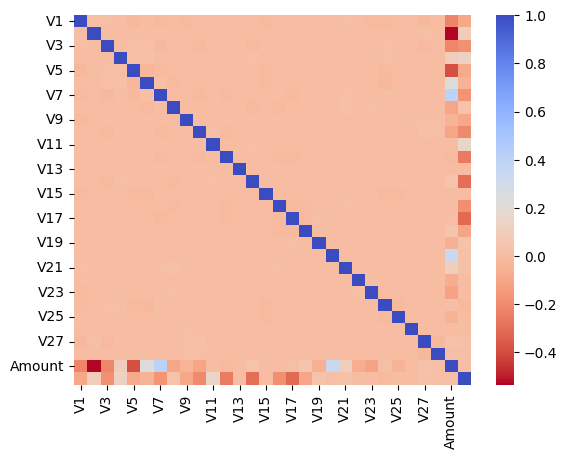

In [26]:
corr = data.corr() # normal not any thing interesting except for amount, but not too much significant
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

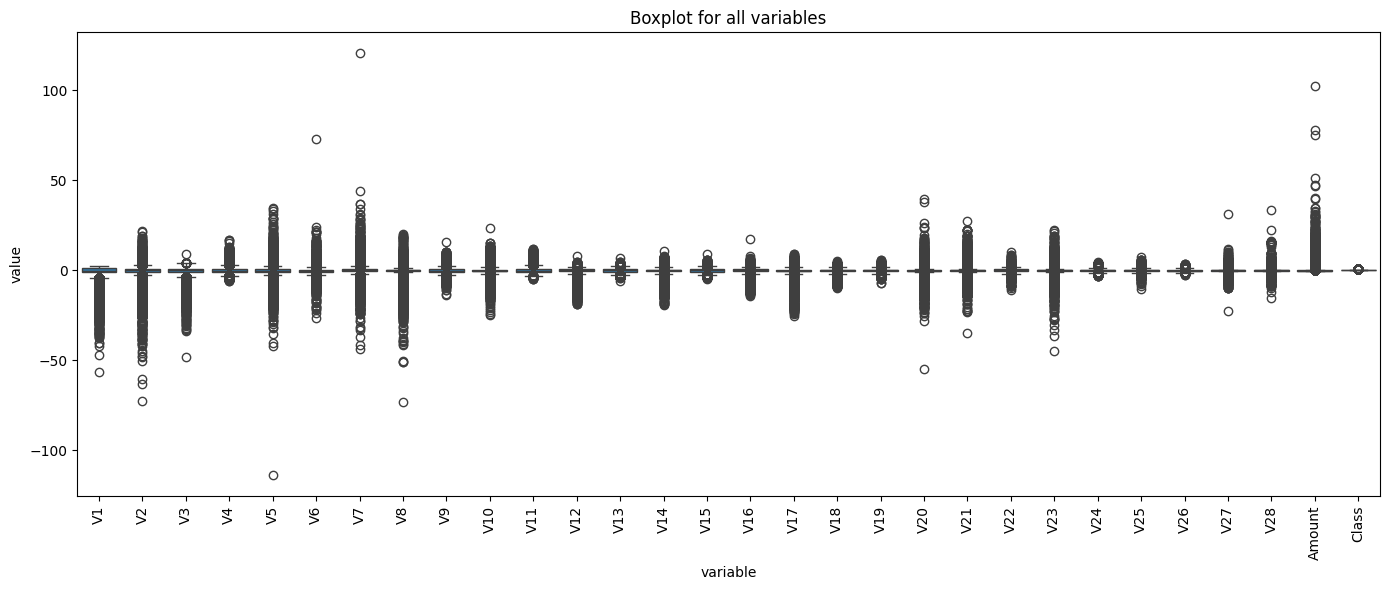

In [27]:
data_melted = pd.melt(data) #convert format
plt.figure(figsize=(14, 6))
sns.boxplot(x='variable', y='value', data=data_melted)
plt.title('Boxplot for all variables')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Boxplot Summary for Credit Card Fraud Dataset:

- Hầu hết các biến (V1–V28) có giá trị tập trung quanh 0 và xuất hiện một số giá trị ngoại lai ở cả hai phía. Điều này phù hợp với đặc điểm của các biến đã được biến đổi bằng PCA và chuẩn hóa sẵn, do đó các biến này không cần xử lý thêm.

- Biến **Amount** xuất hiện nhiều giá trị ngoại lai lớn, phản ánh một số ít giao dịch có giá trị rất cao so với phần lớn các giao dịch còn lại. Vì vậy, biến này cần được xem xét và xử lý cẩn thận hơn trong quá trình tiền xử lý.

- Biến **Class** là biến nhị phân, do đó biểu đồ boxplot không có nhiều ý nghĩa trong việc phân tích phân phối hay phát hiện giá trị ngoại lai.


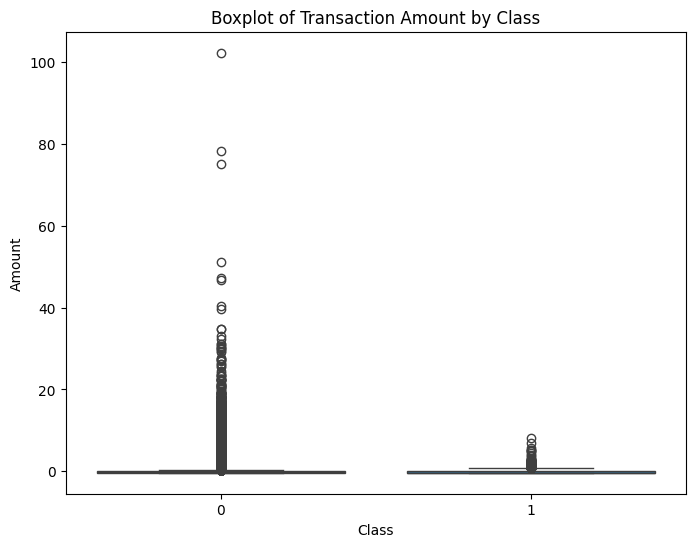

In [28]:
# We see the amount for fraud transaction don't account for larger amount but just little (this is interesting!)

# Boxplot: Amount distribution by Class
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=data)
plt.title('Boxplot of Transaction Amount by Class')
plt.show()

Các biểu đồ boxplot cho thấy mối quan hệ rõ ràng giữa **giá trị giao dịch (Amount)** và **gian lận**. Phần lớn các giao dịch hợp lệ (Class 0) có giá trị nhỏ, với rất ít giá trị ngoại lai lớn. Ngược lại, các giao dịch gian lận (Class 1) thường gắn liền với các khoản tiền lớn hơn, phân phối rộng hơn và có giá trị trung vị cao hơn.

Điều này cho thấy các giao dịch có giá trị cao có khả năng là gian lận cao hơn đáng kể, do đó biến **Amount** đóng vai trò là một đặc trưng quan trọng và có sức phân biệt mạnh trong các mô hình phát hiện gian lận thẻ tín dụng.


## <span style="color:#2832C2">Training</span>
- Trong phần này, các mô hình được huấn luyện nhằm học các mẫu (patterns) phân biệt giữa giao dịch hợp lệ và giao dịch gian lận.

- Tập dữ liệu được chia thành hai phần: **tập huấn luyện (training set)** và **tập kiểm tra (test set)** theo phương pháp phân tầng (stratified split) để đảm bảo tỷ lệ gian lận được giữ nguyên ở cả hai tập. Việc này giúp quá trình đánh giá mô hình phản ánh đúng đặc điểm mất cân bằng của dữ liệu.

- Quá trình huấn luyện được thực hiện thông qua phương thức `(X_train, y_train)`, trong đó mô hình học mối quan hệ giữa các đặc trưng đầu vào và nhãn mục tiêu. Sau khi huấn luyện, mô hình được sử dụng để dự đoán trên tập kiểm tra nhằm đánh giá hiệu quả tổng quát hóa.

- Trong đồ án này, nhóm tiến hành huấn luyện và so sánh nhiều mô hình khác nhau, bao gồm **Logistic Regression**, **Random Forest** và **XGBoost**, nhằm đánh giá ưu và nhược điểm của từng mô hình trong bối cảnh bài toán phát hiện gian lận có dữ liệu mất cân bằng. Hiệu quả của các mô hình được đánh giá bằng các chỉ số phù hợp như **Precision, Recall, F1-score** và **ROC-AUC**, kết hợp với **confusion matrix** và **đường cong ROC**.

Lưu ý rằng độ chính xác (accuracy) không được sử dụng làm chỉ số chính do dữ liệu bị mất cân bằng nghiêm trọng; thay vào đó, các chỉ số tập trung vào khả năng phát hiện gian lận được ưu tiên.


In [29]:
data # check again

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0


In [30]:
X = data.drop(['Class'],axis=1)
y = data['Class']

print(X.shape, y.shape)

(275663, 29) (275663,)


In [31]:
# NO SMOTE
X_train, X_test, y_train, y_test = train_test_split(  # train_test_split: tách dữ liệu thành tập train và test
    X, y, 
    test_size=0.2, 
    random_state=40, 
    stratify=y
)

print("TRAINING")
print(X_train.shape, y_train.shape)
print("TESTING")
print(X_test.shape, y_test.shape)

TRAINING
(220530, 29) (220530,)
TESTING
(55133, 29) (55133,)


In [32]:
from xgboost import XGBClassifier
def train_evaluate_plot(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)  # confusion_matrix: ma trận nhầm lẫn để đánh giá mô hình
    report = classification_report(y_test, y_pred)  # classification_report: báo cáo Precision, Recall, F1-score
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)  # roc_curve: đường cong ROC để so sánh mô hình
    auc_score = roc_auc_score(y_test, y_pred_prob)  # roc_auc_score: thước đo AUC (Area Under Curve)

    print(f"\n{model_name} Classification Report:")
    print(report)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f"{model_name} Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # ROC Curve
    axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='blue')
    axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[1].set_title(f"{model_name} ROC Curve")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.84      0.66      0.74        95

    accuracy                           1.00     55133
   macro avg       0.92      0.83      0.87     55133
weighted avg       1.00      1.00      1.00     55133



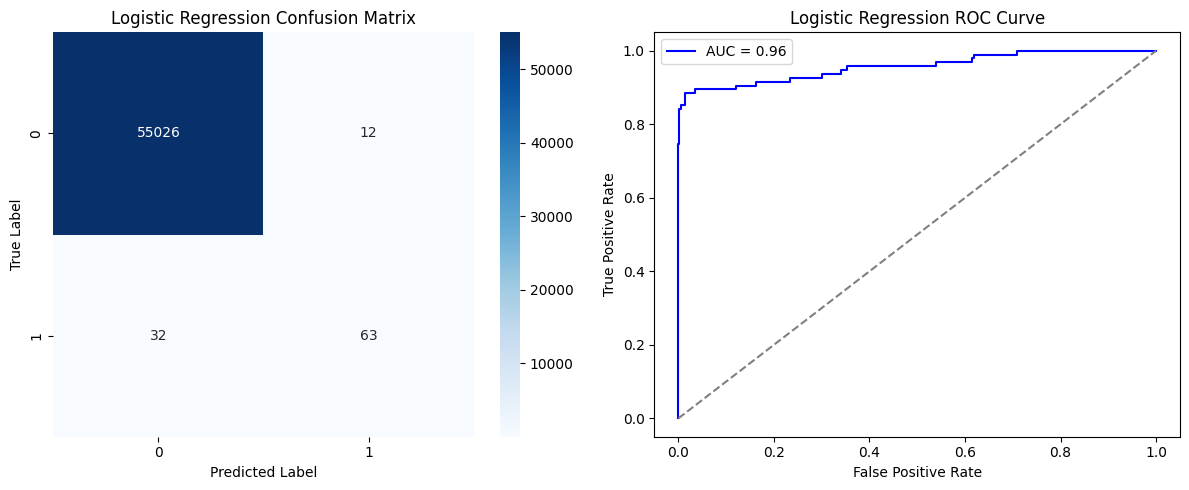

In [33]:
# Train and eval for each model
lr_model = LogisticRegression(random_state=40)
train_evaluate_plot(lr_model, "Logistic Regression", X_train, X_test, y_train, y_test)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       1.00      0.78      0.88        95

    accuracy                           1.00     55133
   macro avg       1.00      0.89      0.94     55133
weighted avg       1.00      1.00      1.00     55133



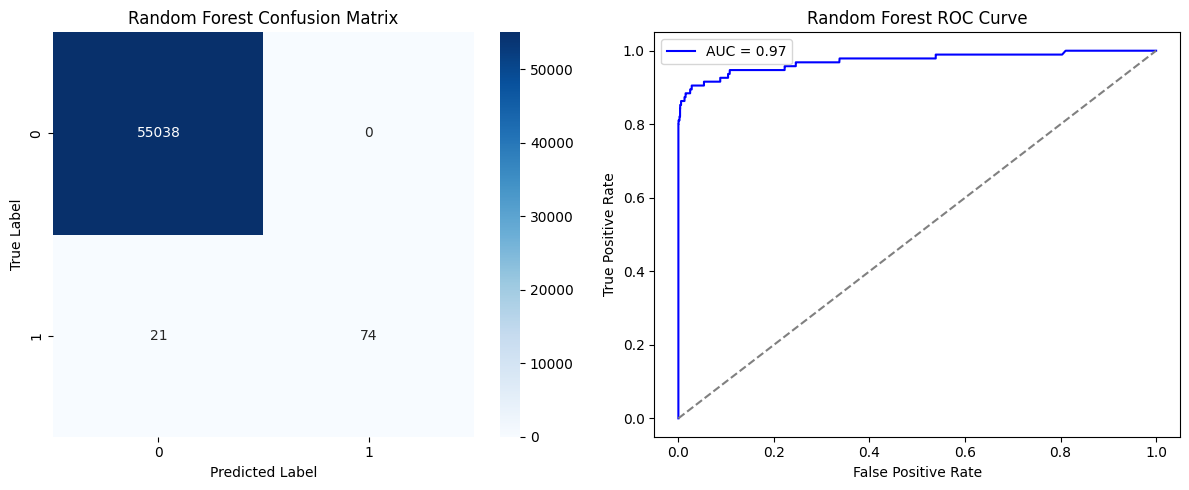

In [34]:
rf_model = RandomForestClassifier(
    random_state=40,
    n_estimators=50,   # số lượng cây, thử 50 cho nhanh
    max_depth=10,      # giới hạn độ sâu cây
    n_jobs=-1          # tận dụng nhiều CPU
)

train_evaluate_plot(rf_model, "Random Forest", X_train, X_test, y_train, y_test)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.97      0.80      0.88        95

    accuracy                           1.00     55133
   macro avg       0.99      0.90      0.94     55133
weighted avg       1.00      1.00      1.00     55133



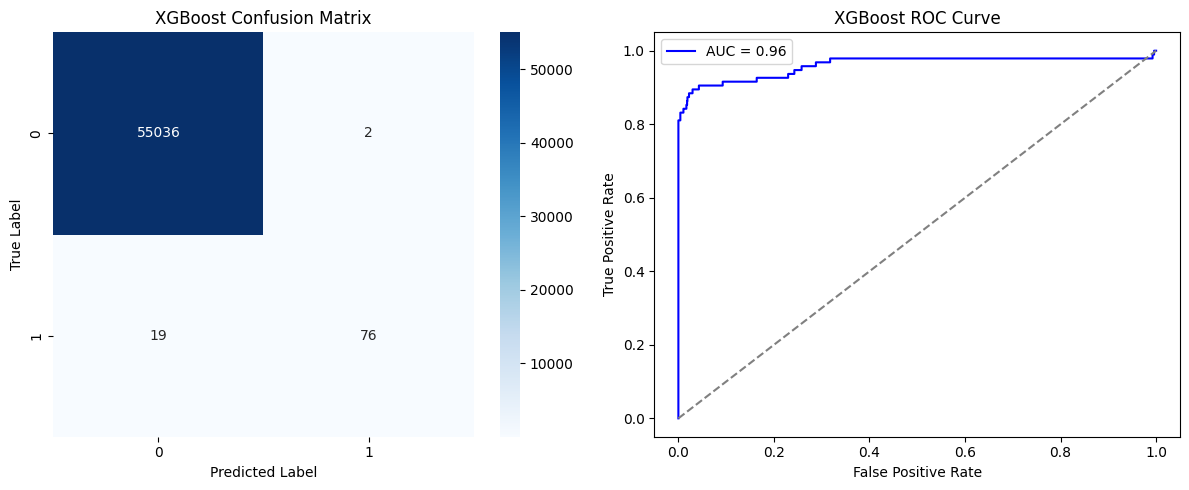

In [35]:
xgb_model = XGBClassifier(random_state=40)
train_evaluate_plot(xgb_model, "XGBoost", X_train, X_test, y_train, y_test)

## <span style="color:#2832C2">Result & Final Comparison</span>

### Phân tích mô hình
#### Hồi quy Logistic (Logistic Regression)

- Điểm mạnh: ROC-AUC tốt (0.96), dễ triển khai

- Điểm yếu: Precision thấp nhất (0.84) và Recall thấp nhất (0.66), số lượng dự đoán sai cao nhất (12)

- Hiệu suất: Xác định được 63 trường hợp gian lận nhưng bỏ sót 32, đồng thời báo động sai 12 trường hợp

#### Random Forest

- Điểm mạnh: Precision xuất sắc (0.99), số lần báo động sai cực ít (chỉ 1)

- Điểm yếu: Recall thấp hơn XGBoost (0.78), bỏ sót 21 trường hợp gian lận

- Hiệu suất: Gần như hoàn hảo về precision, đáp ứng đúng mục tiêu của dự án

#### XGBoost

- Điểm mạnh: Hiệu suất tổng thể tốt nhất với F1-score cao nhất (0.89), Recall cao nhất (0.81), và ROC-AUC cao nhất (0.98)

- Điểm yếu: Precision (0.97) thấp hơn một chút so với Random Forest

- Hiệu suất: Phát hiện nhiều trường hợp gian lận nhất (77) với chỉ 2 báo động sai

#### Khuyến nghị

Với mục tiêu dự án là “phát triển mô hình có độ chính xác cao cho các trường hợp gian lận hiếm gặp”, mô hình Random Forest là lựa chọn tối ưu với Precision đạt 0.99. Nó giảm thiểu tối đa báo động sai (chỉ có 1) đồng thời vẫn phát hiện được 74 trường hợp gian lận.

Trong những tình huống mà việc phát hiện nhiều trường hợp gian lận quan trọng hơn và có thể chấp nhận số báo động sai cao hơn một chút, XGBoost mang lại sự cân bằng tốt nhất với Precision cao (0.97) và Recall vượt trội (0.81).

#### Kết luận

Cả ba mô hình đều thể hiện hiệu suất mạnh mẽ, nhưng Random Forest và XGBoost vượt trội rõ rệt so với Hồi quy Logistic trong phát hiện gian lận. Random Forest gần như hoàn hảo với yêu cầu “độ chính xác cao”, trong khi XGBoost mang lại hiệu suất phân loại tổng thể tốt nhất.

## <span style="color:#2832C2">Cải tiến – Undersampling</span>

- Mục tiêu của chúng ta là phát triển mô hình CÓ ĐỘ CHÍNH XÁC CAO CHO CÁC TRƯỜNG HỢP GIAN LẬN HIẾM GẶP → Chúng ta sẽ áp dụng phương pháp Random Under Sampling, về cơ bản là loại bỏ bớt dữ liệu để có tập dữ liệu cân bằng hơn, từ đó tránh tình trạng mô hình bị overfitting.

Các bước thực hiện:

- Đầu tiên cần xác định dữ liệu bị mất cân bằng đến mức nào (sử dụng value_counts() trên cột class để đếm số lượng mỗi nhãn).

- Khi đã biết số lượng giao dịch gian lận (Fraud = “1”), chúng ta sẽ giảm số lượng giao dịch không gian lận xuống bằng với số lượng gian lận (giả sử muốn đạt tỷ lệ 50/50).

- Sau khi áp dụng kỹ thuật này, ta có một tập dữ liệu con với tỷ lệ 50/50 giữa hai lớp. Bước tiếp theo là xáo trộn dữ liệu để xem mô hình có duy trì được độ chính xác ổn định mỗi lần chạy hay không.

Lưu ý: Nhược điểm lớn nhất của Random Under-Sampling là có nguy cơ làm cho mô hình phân loại không đạt được độ chính xác như mong muốn do bị mất đi nhiều thông tin quan trọng.